# Experiment D2 
- Uma quebra no D para reimplemtação do SVD sem o módulo Surprise

Ideas:

0) Reimplementar o method (classe).

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [2]:
%load_ext watermark

In [3]:
from typing import NewType, List
import functools
import operator
from collections import Counter, defaultdict
from copy import deepcopy
from time import time

import numpy as np
import pandas as pd

from loguru import logger
from tqdm import tqdm

import pythran
from IPython.display import display, Markdown

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

import jax.numpy as npj
from jax import jit

In [4]:
# Run this cell before close.
%watermark
%watermark -p loguru
%watermark -p pythran
%watermark -p pythran
%watermark -p jax
%watermark -p scipy
%watermark --iversion
%watermark -b -r -g

2020-06-28T01:21:07+00:00

CPython 3.7.7
IPython 7.15.0

compiler   : GCC 8.3.0
system     : Linux
release    : 5.4.0-7634-generic
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit
loguru 0.5.1
pythran 0.9.5
pythran 0.9.5
jax 0.1.71
scipy 1.5.0
pandas  1.0.5
pythran 0.9.5
numpy   1.19.0

Git hash: 69ee6f978940c7a08dd9c2ba154ca8f66f0013d6
Git repo: https://github.com/ysraell/aceleradev_private.git
Git branch: master


From exp. D2:

In [153]:

logger.info("Carregando e processando o dataset...")

path_data = '../data/'
top_cols = pd.read_csv('top_cols.csv')['cols'].to_list()
df_marked = pd.read_csv(path_data+'estaticos_market.csv', usecols=top_cols)
col_user = 'id'
top_cols.remove(col_user)

rest_cols = []
for col in top_cols:
    df_marked[col] = df_marked[col].fillna(0)*1
    
def normalize(x):
    return (x-np.min(x))/(np.max(x) - np.min(x)) if (np.max(x) - np.min(x)) > 0 else (x-np.min(x))

escala = 32767
for col in top_cols:
    try:
        df_marked[col] = (escala*normalize(df_marked[col].tolist())).astype(np.int16)
    except:
        maping = {val:i+1 for i,val in enumerate(df_marked[col].unique())}
        df_marked[col] = df_marked[col].apply(lambda x: maping[x])
        df_marked[col] = (escala*normalize(df_marked[col].tolist())).astype(np.int16)
    
remove_cols = []
for col in top_cols:
    if df_marked[col].nunique() == 1:
        remove_cols.append(col)

df_marked = df_marked.drop(columns=remove_cols)
for col in remove_cols:
    top_cols.remove(col)

df_ep_list = [pd.read_csv(path_data+'estaticos_portfolio{}.csv'.format(i+1)) for i in range(3)]
tmp = []
for i in range(3):
    df_ep_list[i]['P'] = i+1 
    tmp.append(df_ep_list[i][['id','P']])
df_ep = pd.concat(tmp)
del df_ep_list
del tmp

logger.info("...pronto!")

2020-06-28 03:22:59.702 | INFO     | __main__:<module>:1 - Carregando e processando o dataset...
2020-06-28 03:23:22.125 | INFO     | __main__:<module>:43 - ...pronto!


In [7]:
!ls *.so && rm -f *.so

ls: cannot access '*.so': No such file or directory


In [8]:
%load_ext pythran.magic

In [9]:
%%pythran -fopenmp
#pythran export normalizeitor(float64[][])
#pythran export transformer(float64[][])
#pythran export vector_distance_pythran(int8[][],int8[])
#pythran export pairwise_distance_pythran(int8[][])
#pythran export pairs_distance_pythran(int8[][],int8[][])

def normalizeitor(x):
    return (x -x.min())/(x.max() - x.min() +1e-10)

def transformer(U):
    for i in range(len(U)):
        U[i] = 127*normalizeitor(U[i])
    return U

def vector_distance_pythran(X,vec):
    return abs(X - vec).sum(-1)

def pairwise_distance_pythran(X):
    i = X.shape[0]
    j = X.shape[1]
    return abs(X.reshape((i, 1, j)) - X).sum(-1)

def pairs_distance_pythran(X,Y):
    i = X.shape[0]
    j = X.shape[1]
    return abs(X.reshape((i, 1, j)) - Y).sum(-1)



In [10]:
!ls *.so

pythranized_b9af09ce3bb3a83c5d007fe0e852e1cd.cpython-37m-x86_64-linux-gnu.so


In [11]:
def flat(a):
    return functools.reduce(operator.iconcat, a, []) 

In [12]:
M = df_marked[df_marked.columns[1:]].values.astype(np.int8)

In [13]:
M.shape

(462298, 86)

In [14]:
type(M)

numpy.ndarray

In [15]:
def np_svd(M):
    u, _, _ = np.linalg.svd(M, full_matrices=False)
    return u

def sp_svds(M,k=10):
    A = csc_matrix(M, dtype=float)
    u, _, _ = svds(A, k=k)
    return u

In [14]:
%timeit sp_svds(M,k=85)
%timeit np_svd(M)

6.27 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.16 s ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
def np_svd_j(M):
    u, _, _ = npj.linalg.svd(M, full_matrices=False)
    return u

In [27]:
np_svd_jit = jit(np_svd_j)

In [28]:
times_list = []
for _ in range(100):
    ts = [0, 0]
    np.random.shuffle(M)
    t = time()
    u = np_svd(M)
    ts[0] = time()-t
    t = time()
    u = np_svd_jit(M)
    ts[1] = time()-t
    times_list.append(ts)

KeyboardInterrupt: 

In [29]:
print(pd.DataFrame(times_list, columns=['NP','NP/JAX/JIT']).describe())

              NP  NP/JAX/JIT
count  65.000000   65.000000
mean    6.456229    0.088340
std     0.410914    0.006072
min     5.522225    0.085672
25%     6.164910    0.086201
50%     6.426472    0.087034
75%     6.687413    0.088206
max     7.492672    0.134185


In [18]:
def vector_distance(X,vec):
    return abs(X - vec).sum(-1)

def pairwise_distance(X):
    return abs(X[:, None, :] - X).sum(-1)

def pairs_distance(X,Y):
    return abs(X[:, None, :] - Y).sum(-1)

def vector_distance_float(X,vec):
    return abs((X - vec).astype(npj.float32)).sum(-1)

def pairwise_distance_float(X):
    return abs((X[:, None, :] - X).astype(npj.float32)).sum(-1)

def pairs_distance_float(X,Y):
    return abs((X[:, None, :] - Y).astype(npj.float32)).sum(-1)

In [19]:
vector_distance_jit = jit(vector_distance_float)
pairwise_distance_jit = jit(pairwise_distance_float)
pairs_distance_jit = jit(pairs_distance_float)

In [24]:
times_list = []
N = 100
for i in range(N):
    print("{}/{}     ".format(i+1,N), end='\r')
    ts = [0, 0, 0]
    np.random.shuffle(M)
    M = deepcopy(transformer(M.astype(np.float64)).astype(np.int8))
    vec = deepcopy(M[0])
    t = time()
    _ = vector_distance(M,vec)
    ts[0] = time()-t
    t = time()
    _ = vector_distance_pythran(M,vec)
    ts[1] = time()-t
    A = M.astype(npj.float32)
    t = time()
    _ = vector_distance_jit(M,vec)
    ts[2] = time()-t
    times_list.append(ts)

In [25]:
print(pd.DataFrame(times_list, columns=['Pure','Pythran','JAX/JIT']).describe()) 

             Pure     Pythran     JAX/JIT
count  100.000000  100.000000  100.000000
mean     0.063400    0.112105    0.088542
std      0.001113    0.001848    0.001555
min      0.059621    0.108312    0.084327
25%      0.063058    0.111101    0.087858
50%      0.063367    0.111656    0.088423
75%      0.063740    0.112479    0.088999
max      0.068604    0.119318    0.098682


In [55]:
20 in df_marked.index

True

In [154]:

Uid = NewType('uid', int)
Raw = NewType('raw', str)

class ExSVD():
    """
        Classe para SVD.
        
    
    """
    def __init__(self,stateless: bool = False):
        self.matrix_dict = {}
        self.stateless = stateless
        self.M = None
        self.pu = None
        self.raw = None
        self.uid = None

    def fit(self,dataset: pd.DataFrame):
        """
            ...
        """
        self.M = dataset[dataset.columns[1:]].values.astype(np.int16)
        self.raw = dataset[dataset.columns[0]].to_dict()
        self.uid = {raw:uid for uid,raw in self.raw.items()}
        self.all_raw = dataset[dataset.columns[0]].tolist()
        self.all_uid = dataset.index
        
    def _get_neighbors(self,uid: Uid, k: int = 1, black_list: List[Uid] = []) -> List[Uid]:
        """
            Calcula todas as distâncias entre 'uid' de entrada e todos os outros 'uid'.
            A distância calciulada é armazenda e não calculada novamente. 
        """
        k = k if k >= 0 else 0
        #logger.info("Calculando todos os vizinhos...")
        #for uid2 in tqdm(self.trainset.all_users()):
        if uid not in self.matrix_dict.keys():
            self.matrix_dict[uid] = vector_distance(self.M,self.M[uid])
        out = [x[0] for x in sorted(
            [
                (uid2, self.matrix_dict[uid][uid2])
                for uid2 in self.all_uid
                if (uid2 not in black_list)
            ], key=lambda x: x[1])][:k]
        if self.stateless:
            del self.matrix_dict
            self.matrix_dict = {}
        return out
    
    def _uid2raw(self, uid: Uid)-> str:
        '''
            uid -> raw.
            Valor interno para externo, o nome original do usuário.
        '''
        return self.raw[uid]
    
    def _raw2uid(self, raw: Raw)-> int:
        '''
            raw -> uid.
            Valor externo para interno, o id interno do usuários..
        '''
        return self.uid[raw]
    
    def recomender(self, in_list: List[Raw], k: int = 1, L: int = 3, Fk: int = 1, limit: int = 100)-> List[Raw]:
        '''
            Faz as recomendacoes.
            ##### Função incompleta #####
        '''
        # Pega quantas recomendações por usuário em `in_list`,
        # mas sem deixar faltar
        N_in = len(in_list)
        k = k if k > 0 else 1
        R_per_in = L*(k//N_in + min(k%N_in,1))

        # Pega os `uid`
        uid_in_list = [self._raw2uid(raw) for raw in in_list]

        # Pega os vizinhos mais próximos de cada uid de entrada.
        done = False
        flag = True
        Rounds = 0
        while limit and (not done):
            Rounds += 1
            # Ele sempre pega todos novamente.
            recomendations_list = [self._get_neighbors(uid,R_per_in,uid_in_list) for uid in uid_in_list]
            # Quando limit = 0, encerra.
            limit -= 1
            # Quando tem gente o suficiente, encerra.
            if len(set(flat(recomendations_list))) >= Fk*k:
                done = True
            # Depois do primeiro loop, pega um a mais.
            R_per_in += 1

        # Aqui gera um dicionário ordenando por votacao.
        count_rec = Counter(flat(recomendations_list)) # A votação!!
        count_rec = list(count_rec.items())
        ct_pos = defaultdict(list)
        #ct_pos_inv = defaultdict(list)
        while count_rec:
            tmp = count_rec.pop(0)
            ct_pos[tmp[1]].append(tmp[0])
            #ct_pos_inv[tmp[0]].append(tmp[1])

        # Aqui considera a posiçao de vizinhos mais proximos.
        #nn_pos = defaultdict(list)
        nn_pos_inv = defaultdict(list)
        tmp = deepcopy(recomendations_list)
        while tmp:
            tmp2 = tmp.pop(0)
            n = 0
            while tmp2:
                n += 1
                tmp3 = tmp2.pop(0)
                #nn_pos[n].append(tmp3)
                nn_pos_inv[tmp3].append(n)

        # Vai separando por votação e ordem de proximidade como desempate.      
        votos_list = list(ct_pos.keys())
        out_uid = []
        while votos_list and k:
            votos = max(votos_list)
            votos_list.remove(votos)
            tmp = sorted([(tmp, min(nn_pos_inv[tmp])) for tmp in ct_pos[votos]], key=lambda x: x[1])
            while tmp and k:
                out_uid.append(tmp.pop(0)[0])
                k -= 1

        # converte para Raw e "joga fora".
        return [self._uid2raw(uid) for uid in out_uid]


In [155]:
ex_algo = ExSVD()
ex_algo.fit(df_marked)

Passo de validação simples, para cada uma empresa no portfólio pegar N recomendações e ver se uma delas está no portfólio. Se está, soma 1, se não, soma 0.

In [156]:
N = 1
tmp = []
n = 0
Nu = len(df_ep)
times = []
for row in df_ep.iterrows():
    t = time()
    n += 1
    print("Empresa {:,}/{:,}.".format(n,Nu), end='\r')
    recs = ex_algo.recomender([row[1].id],k=N)
    tmp.append([row[1].P, any([x in df_ep.loc[df_ep.P == row[1].P].id.to_list() for x in recs])*1])
    times.append(time()-t)
    

In [160]:
pd.DataFrame(times, columns=['time']).describe()

,time
count,1386.000000
mean,0.772800
std,0.024298
min,0.691081
25%,0.768004
50%,0.773729
75%,0.782389
max,1.058321


In [162]:
pd.DataFrame(tmp, columns=['P','True'])['True'].sum()

195

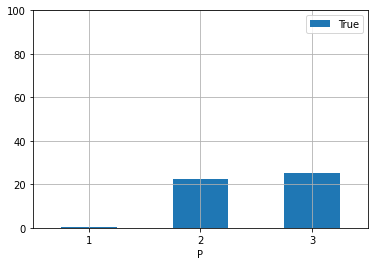

In [163]:
df = pd.DataFrame(tmp, columns=['P','True']).groupby('P').agg(list).reset_index()
df['True'] = df['True'].apply(lambda x: 100*sum(x)/len(x))
df.set_index('P').plot.bar(grid=True, rot=0, ylim=(0,100))

In [164]:
print(df.set_index('P'))

        True
P           
1   0.360360
2  22.261484
3  25.283019


In [165]:
df = pd.DataFrame(tmp, columns=['P','True'])
df.loc[df.P == 1].sum()

P       555
True      2
dtype: int64

**Item 0 pronto**